In [ ]:
import torch
import torchvision
from torchvision.models import vgg16, resnet50
import torchvision.transforms as transforms
## Standard Library
import time
import struct

## External Library
import numpy as np
import matplotlib.pyplot as plt

## Pytorch Imports
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable

In [ ]:
class GradientAttack():

        """

        """

        def __init__(self, loss, epsilon):
            """

            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y_true, model):
            """

            """
            # TODO: Implement a one step gradient attack
            # Step 1: Calculate the Loss and then calculate the
            # gradient of the Loss w.r.t the image
            # Forward pass
            output = model(x)

            # Calculate the loss between the output and the target label
            calculated_loss = self.loss(output, torch.tensor(y_true))

            # Zero-out any previously calculated gradients
            model.zero_grad()
            x.grad = None

            # Calculate gradients of the loss with respect to the input tensor
            calculated_loss.backward()

            # Step 2: Add the gradient (or its sign for each pixel),
            # multiplied by a small step size, to
            # the original image
            # you might need to clamp the modified image to
            # make sure the values of each pixel are between [0,1]

            # Perturb the input tensor using the calculated gradients
            perturbed_input = x + self.epsilon * torch.sign(x.grad)

            # Clip the perturbed input within a valid range
            perturbed_input = torch.clamp(perturbed_input, 0, 1)

            # Update the input tensor to the perturbed input for the next iteration
            x = perturbed_input

            return x.detach()  # Return the perturbed input tensor without gradients




In [ ]:
## Transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(64)])

## Batch Size
batch_size = 128

## Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 37090322.47it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
## Helper
def initialize_model(use_resnet=True, pretrained=False, nclasses=10):
    """

    """
    ## Initialize Model
    if use_resnet:
        model = resnet50(pretrained=pretrained)
    else:
        model = vgg16(pretrained=True)
    ## Freeze Early Layers if Pretrained
    if pretrained:
        for parameter in model.parameters():
            parameter.requires_grad = False
    ## Update Output Layer
    if use_resnet:
        model.fc = nn.Linear(2048, nclasses)
    else:
        model.classifier._modules['6'] = nn.Linear(4096, nclasses)
    return model

## Get Model
net = initialize_model(True, False, 10)
gpu_boole = torch.cuda.is_available()
print(gpu_boole)
if gpu_boole:
  net.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


True


In [ ]:
## Initialize The Attack
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
loss_metric = nn.CrossEntropyLoss()

adv_attack = GradientAttack(loss_metric, 0.1)

In [ ]:
## Evaluation Functions (E.g Loss, Accuracy)
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in trainloader:
      if gpu_boole:
          images, labels = images.cuda(), labels.cuda()
      #images = images.view(-1, 3, 32, 32)
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted.float() == labels.float()).sum()

      loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Train accuracy: %f %%' % (100.0 * correct / total))
        print('Train loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in testloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        #images = images.view(-1, 3, 32, 32)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

def test_eval_adv(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in testloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        #images = images.view(-1, 3, 32, 32)
        images = Variable(images, requires_grad=True)
        images = adv_attack.forward(images, Variable(labels), net)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy adversarial: %f %%' % (100.0 * correct / total))
        print('Test loss adversarial: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total




Starting Training
Epoch 1 :
Train accuracy: 60.283997 %
Train loss: 0.008698
Test accuracy: 52.840000 %
Test loss: 0.010629


<ipython-input-2-646958dbd934>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  calculated_loss = self.loss(output, torch.tensor(y_true))


Test accuracy adversarial: 29.490000 %
Test loss adversarial: 0.017764
Elapsed time for epoch: 142.99442076683044 s
ETA of completion: 21.449163115024568 minutes


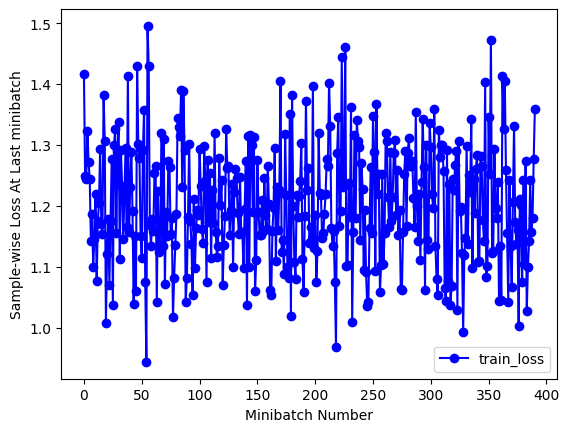

Epoch 2 :
Train accuracy: 66.570000 %
Train loss: 0.007434
Test accuracy: 55.619999 %
Test loss: 0.009882
Test accuracy adversarial: 30.170000 %
Test loss adversarial: 0.017359
Elapsed time for epoch: 141.62855768203735 s
ETA of completion: 18.883807690938315 minutes


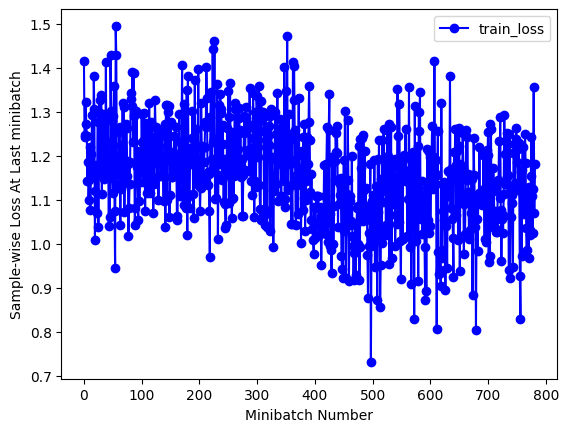

Epoch 3 :
Train accuracy: 67.599998 %
Train loss: 0.007272
Test accuracy: 54.189999 %
Test loss: 0.010631
Test accuracy adversarial: 29.359999 %
Test loss adversarial: 0.019008
Elapsed time for epoch: 142.8064796924591 s
ETA of completion: 16.66075596412023 minutes


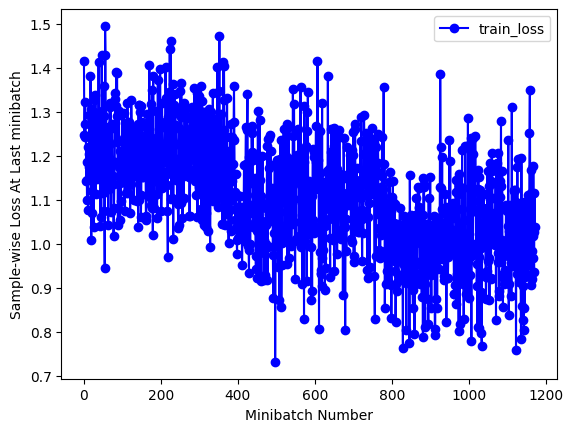

Epoch 4 :
Train accuracy: 70.003998 %
Train loss: 0.006526
Test accuracy: 55.189999 %
Test loss: 0.010582
Test accuracy adversarial: 31.259998 %
Test loss adversarial: 0.019162
Elapsed time for epoch: 142.86414909362793 s
ETA of completion: 14.286414909362794 minutes


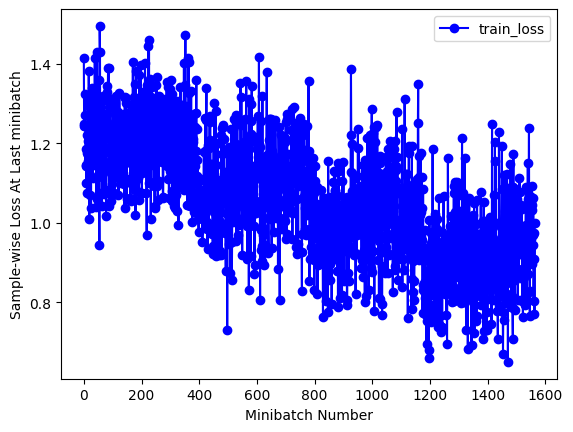

Epoch 5 :
Train accuracy: 74.930000 %
Train loss: 0.005530
Test accuracy: 56.689999 %
Test loss: 0.010486
Test accuracy adversarial: 30.980000 %
Test loss adversarial: 0.020151
Elapsed time for epoch: 142.9651312828064 s
ETA of completion: 11.913760940233866 minutes


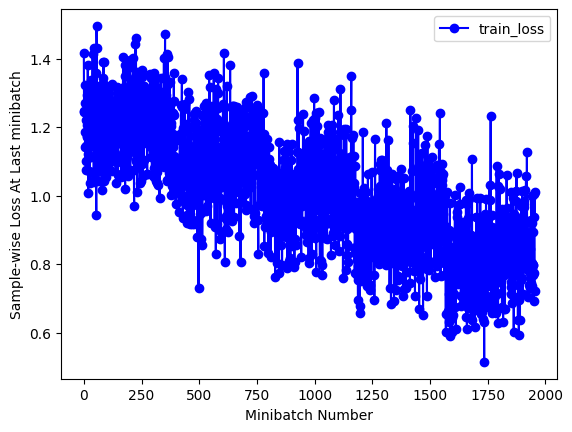

Epoch 6 :
Train accuracy: 76.965996 %
Train loss: 0.005080
Test accuracy: 55.359997 %
Test loss: 0.011088
Test accuracy adversarial: 29.849998 %
Test loss adversarial: 0.021912
Elapsed time for epoch: 141.9094123840332 s
ETA of completion: 9.46062749226888 minutes


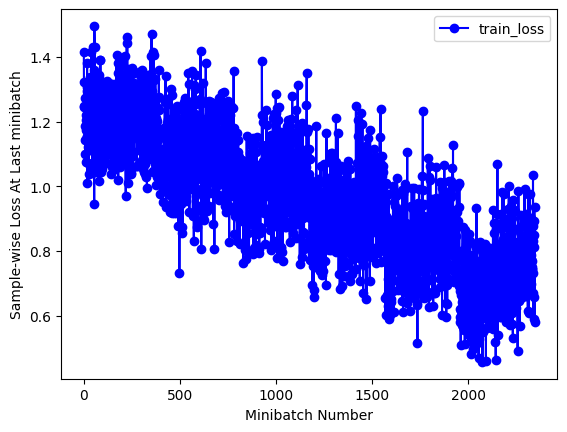

Epoch 7 :
Train accuracy: 82.049995 %
Train loss: 0.004019
Test accuracy: 56.189999 %
Test loss: 0.011369
Test accuracy adversarial: 30.820000 %
Test loss adversarial: 0.022757
Elapsed time for epoch: 143.72177863121033 s
ETA of completion: 7.1860889315605165 minutes


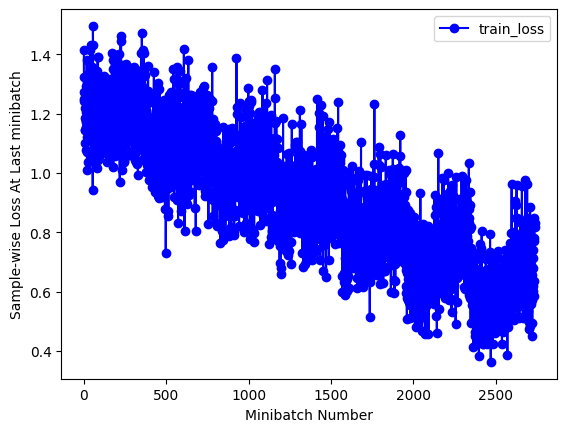

Epoch 8 :
Train accuracy: 83.515999 %
Train loss: 0.003653
Test accuracy: 56.480000 %
Test loss: 0.012009
Test accuracy adversarial: 30.580000 %
Test loss adversarial: 0.024456
Elapsed time for epoch: 142.92536115646362 s
ETA of completion: 4.764178705215454 minutes


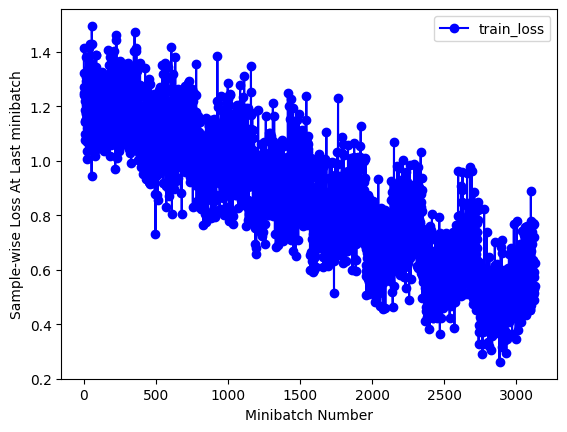

Epoch 9 :
Train accuracy: 88.540001 %
Train loss: 0.002568
Test accuracy: 57.309998 %
Test loss: 0.012112
Test accuracy adversarial: 31.070000 %
Test loss adversarial: 0.025308
Elapsed time for epoch: 144.41039633750916 s
ETA of completion: 2.406839938958486 minutes


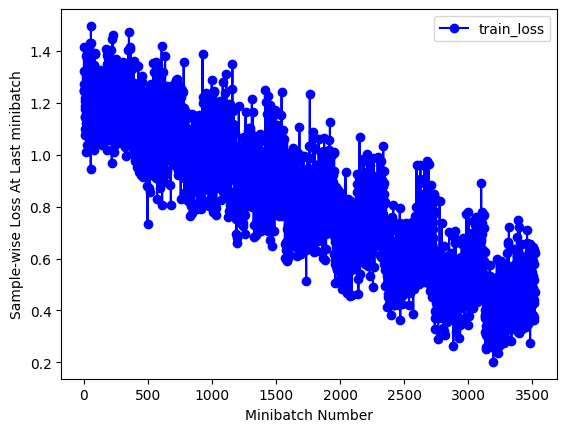

Epoch 10 :
Train accuracy: 89.327995 %
Train loss: 0.002441
Test accuracy: 57.359997 %
Test loss: 0.012927
Test accuracy adversarial: 31.469999 %
Test loss adversarial: 0.027259
Elapsed time for epoch: 144.66894102096558 s
ETA of completion: 0.0 minutes


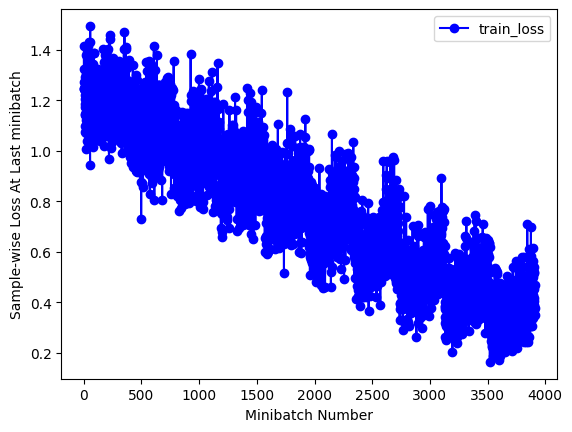

In [ ]:
# Number of epochs to train for
epochs = 10

# Define batch train loss recording array for later visualization/plotting
loss_batch_store = []

print("Starting Training")

# Training loop
for epoch in range(epochs):
    time1 = time.time()  # Timekeeping

    for i, (x, y) in enumerate(trainloader):
        x, y = x.cuda(), y.cuda()
        x.requires_grad = True  # Ensure the input tensor requires gradients

        optimizer.zero_grad()

        # Forward pass
        outputs = net(x)
        loss = loss_metric(outputs, y)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Record loss
        loss_batch_store.append(loss.item())

    print("Epoch", epoch + 1, ':')
    train_perc, train_loss = train_eval()
    test_perc, test_loss = test_eval()
    test_eval_adv()


    time2 = time.time()  # Timekeeping
    print('Elapsed time for epoch:', time2 - time1, 's')
    print('ETA of completion:', (time2 - time1) * (epochs - epoch - 1) / 60, 'minutes')

    # Plot batch-wise train loss curve
    plt.plot(loss_batch_store, '-o', label='train_loss', color='blue')
    plt.xlabel('Minibatch Number')
    plt.ylabel('Sample-wise Loss At Last minibatch')
    plt.legend()
    plt.show()

In [1]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
idx = np.random.randint(0, len(testset))
label = testset[idx][1]
if gpu_boole:
  img = testset[idx][0].unsqueeze(0).cuda()  # Move the input image tensor to the GPU
  net.cuda()
net.eval()

output = net(img)
_, predicted = torch.max(output.data, 1)
# Convert the image and show it
img = img.squeeze().permute(1, 2, 0).cpu()  # Move the image tensor back to the CPU and adjust dimensions
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {classes[predicted]}, True: {classes[label]}')
plt.show()


generated = adv_attack.forward(img, Variable(label), net)
output = net(generated)
_, predicted = torch.max(output.data, 1)
generated = generated.squeeze().permute(1, 2, 0).cpu()
plt.imshow(generated)
plt.axis('off')
plt.title(f'Predicted: {classes[predicted]}')
plt.show()

NameError: ignored